# Point cloud odometry
We can use the point clouds to refine the trajectory want to refine the results from the original trajectory. For this the typical approach is the iterative Closest Point algorithm. I have tested Point-to-Plane ICP, Multi-scale ICP and Colored ICP 

In [4]:
import open3d as o3d
import numpy as np
from reconstruction.dataset import Dataset
import reconstruction.utils.visualization as vis



def draw_registration_result(source, target, transformation):
    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    transformed_target = target.clone().transform(transformation)
    vis.visualize_geometry([source.to_legacy(),
         transformed_target.to_legacy()], flip=True)


def extract_point_cloud(depth_file: str, color_file: str, intrinsic: o3d.core.Tensor) -> o3d.geometry.PointCloud:
    depth_image = o3d.t.io.read_image(depth_file)
    color_image = o3d.t.io.read_image(color_file)
    rgbd_image = o3d.t.geometry.RGBDImage(color_image, depth_image)
    
    pcd = o3d.t.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        intrinsic,
        depth_scale=1000.0,
        depth_max=0.5)

    return pcd


def icp_point_to_plane(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane()
    criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                        relative_rmse=0.0000001,
                                        max_iteration=100)
    max_correspondence_distance = 0.015

    reg = o3d.t.pipelines.registration.icp(source, target, max_correspondence_distance,
                                initial_transform, estimation, criteria, voxel_size=0.005)
    
    return reg


dataset = Dataset.read("data/3d-scans-cap-black-glossy-ha-2019-02-27T16_06_29")
source_frame = dataset.frames[51]
target_frame = dataset.frames[63]
camera_intrinsic = o3d.core.Tensor([[613.688, 0.0, 323.035], 
                            [0.0, 614.261, 242.229], 
                            [0.0, 0.0, 1.0]])

source = extract_point_cloud(source_frame.depth_file, source_frame.color_file, camera_intrinsic)
target = extract_point_cloud(target_frame.depth_file, target_frame.color_file, camera_intrinsic)
target.estimate_normals()
relative_transform = np.matmul(np.linalg.inv(source_frame.get_transform()), target_frame.get_transform())
# vis.visualize_geometry([source.to_legacy(), target.to_legacy().transform(relative_transform)], flip=True)
o3d.visualization.draw_geometries([source.to_legacy(), target.to_legacy().transform(relative_transform)])

registration_result = icp_point_to_plane(source, target, np.linalg.inv(relative_transform))
print("Inlier Fitness: ", registration_result.fitness)
print("Inlier RMSE: ", registration_result.inlier_rmse)
# draw_registration_result(source, target, registration_result.transformation)
o3d.visualization.draw_geometries([source.to_legacy(), target.to_legacy().transform(np.linalg.inv(registration_result.transformation.numpy()))])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Inlier Fitness:  0.969037508846426
Inlier RMSE:  0.003349540184943701


  0%|          | 0/194 [00:00<?, ?it/s]

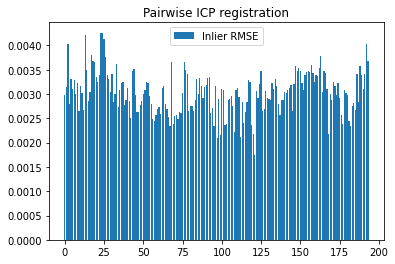

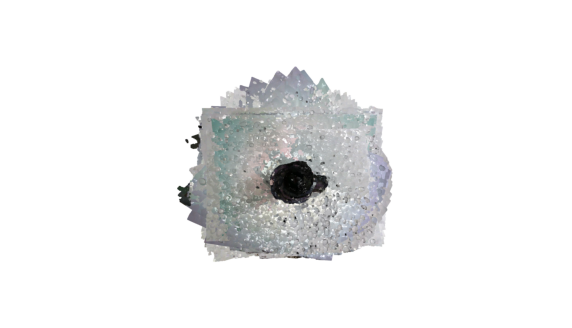

0.5889902579554971

In [7]:
from tqdm.notebook import tqdm
from itertools import accumulate
from more_itertools import pairwise
import matplotlib.pyplot as plt
import logging

def register_frames(dataset: Dataset, method):
    progress_bar = tqdm(total=len(dataset.frames) - 1)
    meshes = []
    inlier_rmses = []

    transforms = []
    prev_point_cloud = None
    for source_frame, target_frame in pairwise(dataset.frames):
        source_point_cloud = extract_point_cloud(source_frame.depth_file, source_frame.color_file, camera_intrinsic) if prev_point_cloud is None else prev_point_cloud
        target_point_cloud = extract_point_cloud(target_frame.depth_file, target_frame.color_file, camera_intrinsic)
        target_point_cloud.estimate_normals()
        initial_transform = np.matmul(np.linalg.inv(source_frame.get_transform()), target_frame.get_transform())
        
        try:
            registration_result = method(source_point_cloud, target_point_cloud, np.linalg.inv(initial_transform))
            transforms.append(np.matmul(source_frame.get_transform(), np.linalg.inv(registration_result.transformation.numpy())))
            meshes.append(target_point_cloud.to_legacy())
            
            inlier_rmses.append(registration_result.inlier_rmse)
            progress_bar.set_description(f"Registered frame {source_frame.id} to {target_frame.id}")
            progress_bar.set_postfix(fitness=registration_result.fitness, inlier_rmse=registration_result.inlier_rmse)
            progress_bar.update()
            prev_point_cloud = target_point_cloud

        except RuntimeError as e:
            logging.warning(e)
            inlier_rmses.append(0)
            progress_bar.update()

    progress_bar.close()

    for transform, mesh in zip(transforms, meshes):
        mesh.transform(transform)

    x = np.arange(0, len(inlier_rmses))
    y = inlier_rmses
    fig = plt.figure()
    ax = plt.axes()
    plt.title("Pairwise ICP registration")
    ax.bar(x, y, label="Inlier RMSE")
    ax.legend()

    vis.visualize_geometry(meshes, flip=False)
    o3d.visualization.draw_geometries(meshes)

    return np.sum(inlier_rmses)
register_frames(dataset, method=icp_point_to_plane)

  0%|          | 0/194 [00:00<?, ?it/s]

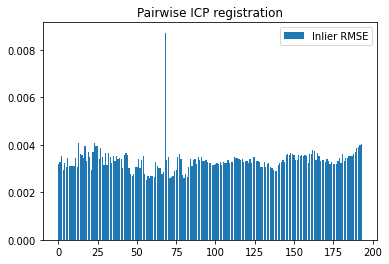

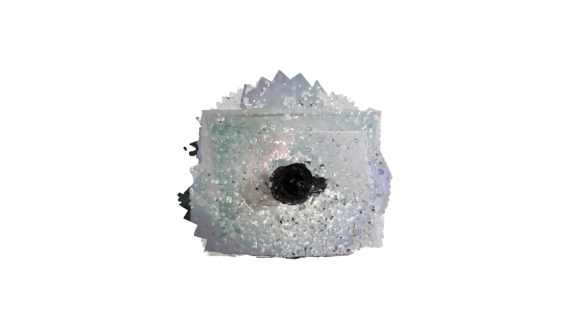

  0%|          | 0/194 [00:00<?, ?it/s]

[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

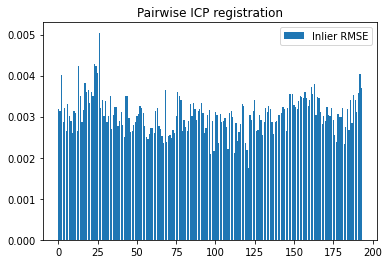

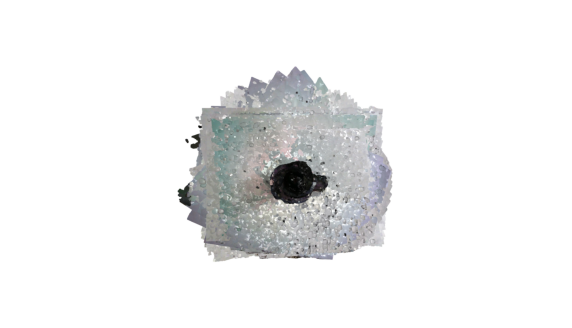

  0%|          | 0/194 [00:00<?, ?it/s]

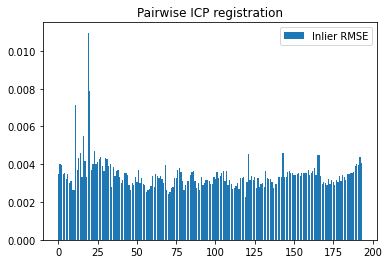

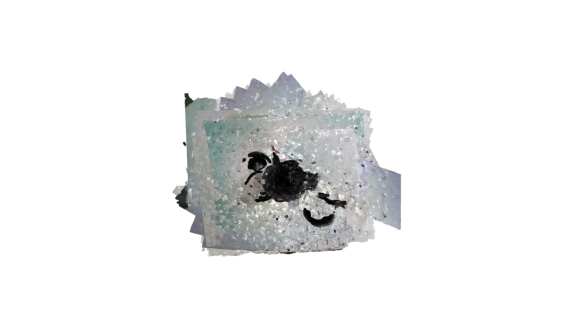


Baseline RMSE: 0.6476555045308361
Point-to-plane ICP RMSE: 0.5930305164586929
Colored ICP RMSE: 0.6660628546712324


In [8]:
from IPython.display import display, Markdown

def icp_color(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationForColoredICP()
    criterias = [
        o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0001,
                                    relative_rmse=0.0001,
                                    max_iteration=100),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.00001, 0.00001, 30),
        o3d.t.pipelines.registration.ICPConvergenceCriteria(0.000001, 0.000001, 15)
    ]
    max_correspondence_distances = o3d.utility.DoubleVector([0.06, 0.03, 0.015])
    voxel_sizes = o3d.utility.DoubleVector([0.02, 0.01, 0.005])

    reg_point_to_plane_color = o3d.t.pipelines.registration.multi_scale_icp(source, target, voxel_sizes, criterias, max_correspondence_distances,
                                initial_transform, estimation)

    return reg_point_to_plane_color

def noop(source: o3d.core.Tensor, target: o3d.core.Tensor, initial_transform: np.ndarray) -> np.ndarray:
    estimation = o3d.t.pipelines.registration.TransformationEstimationPointToPlane()
    criteria = o3d.t.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.0000001,
                                        relative_rmse=0.0000001,
                                        max_iteration=0)
    max_correspondence_distance = 0.015

    reg = o3d.t.pipelines.registration.icp(source, target, max_correspondence_distance,
                                initial_transform, estimation, criteria, voxel_size=0.005)
    
    return reg

baseline_rmse = register_frames(dataset, method=noop)
icp_rmse = register_frames(dataset, method=icp_point_to_plane)
icp_color_rmse = register_frames(dataset, method=icp_color)

display(Markdown(f"""
**Baseline RMSE: {baseline_rmse}
**Point-to-plane ICP RMSE:** {icp_rmse}
**Colored ICP RMSE:** {icp_color_rmse}
"""))